In [21]:
import random
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [22]:
from nn import MLP, Layer, Neuron
from engine import Value

In [23]:
np.random.seed(1337)
random.seed(1337)

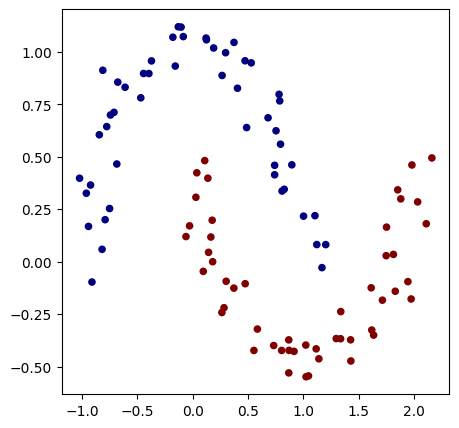

In [24]:
from sklearn.datasets import make_moons, make_blobs
'''
make_moons(n_samples=100, noise=0.1): This function generates a synthetic dataset that forms two interleaving crescent shapes 
(resembling two moons). It is often used for testing binary classification algorithms.

n_samples=100: This parameter specifies that 100 samples (data points) should be generated.
noise=0.1: This adds some random noise to the data, making the moon shapes less perfect and adding variability.
X: This is the feature matrix (of shape 100×2), where each row is a 2D coordinate of a data point.
y: This is the label array (of shape 100), where each entry is either 0 or 1, representing the class labels for the two different 
moon shapes.
'''
X, y = make_moons(n_samples = 100, noise = 0.1)

'''
Label adjustment: This line transforms the labels to -1 and 1 by applying a simple transformation. This transformation is often done when 
working with certain machine learning models (such as SVMs or binary classifiers) that expect binary labels to be in the 
range of -1 and 1 instead of 0 and 1. This label array is essential because it is the target that machine learning models use to learn how 
to classify the data points. In classification problems, the labels provide the ground truth that the model tries to predict.
'''
y = 2*y - 1 # 

# This creates a figure object with a square aspect ratio of size 5x5 inches.
plt.figure(figsize=(5, 5))

'''
plt.scatter(X[:,0], X[:,1], c=y, s=20, cmap='jet'): This creates a scatter plot of the data points in 2D space.

X[:, 0]: The x-coordinates of the points (first column of the feature matrix X).
X[:, 1]: The y-coordinates of the points (second column of the feature matrix X).
c=y: The color of each point is determined by the class label (y), where -1 and 1 are represented with different colors.
s=20: This specifies the size of the points in the plot (each point has a size of 20).
cmap='jet': The color map (jet) is used to color the points based on their labels. 
Points with label -1 will be one color, and points with label 1 will be another color.

c=y: The values in y determine which data points are assigned which colors. In your example, y contains labels -1 and 1. 
So, the plot will map these two values to colors.
cmap='jet': The "jet" colormap defines the specific colors that are used for the values in y. For example, -1 might be represented by blue,
and 1 might be represented by red. The colormap provides the gradient of colors based on the values in y.
'''
plt.scatter(X[:, 0], X[:, 1], c=y, s=20, cmap='jet')

In [38]:
# initialize a model 
model = MLP(2, [16, 16, 1]) # 2-layer neural network
print(model)
print("number of parameters", len(model.parameters()))

MLP(3 Layers)
number of parameters 337


In [39]:
def loss(batch_size = None):
    # inline DataLoader :)
    if batch_size is None:
        Xb, yb = X, y
    else:
        # If a batch_size is provided, they will contain a random selection of the full dataset. 
        ri = np.random.permutation(X.shape[0])[:batch_size]
        Xb, yb = X[ri], y[ri]

    # The data Xb is transformed into a list of Value objects for each row in Xb
    inputs = [list(map(Value, xrow)) for xrow in Xb]
    
    # This applies the model to each input in inputs and computes the scores for each data point.
    scores = list(map(model, inputs)) # forward pass

    # svm "max-margin" loss
    '''
    The SVM (Support Vector Machine) max-margin loss is used in classification tasks, particularly binary classification, 
    to maximize the "margin" between two classes. The margin is the distance between the decision boundary (the line or hyperplane 
    that separates the classes) and the closest data points from each class.

    The key idea is to find the hyperplane that separates the two classes with the maximum possible margin while still correctly 
    classifying as many points as possible.

    This loss function encourages two things:

    Correct classification: If the product yi*f(xi) is greater than or equal to 1 (meaning the predicted score has the same sign as the 
    label and is at least 1 unit away from 0), the loss is 0, indicating a correct and confident classification. 
    Maximizing the margin: If the product is less than 1, the loss is proportional to how far the prediction is from the ideal margin. 
    The farther the prediction is from the margin, the greater the loss.
    
    Thus, the SVM loss encourages the decision boundary to be placed as far as possible from the nearest points of each class 
    (maximizing the margin) while penalizing points that fall inside the margin or are misclassified.

    This calculates the SVM loss for each data point. The SVM loss function is based on the concept of maximizing the margin between classes:
    1 + -yi * scorei: The SVM loss is computed as 
    max(0, 1 − 𝑦𝑖⋅score𝑖), where 
    ​ 𝑦𝑖 is the label and 
    ​ score𝑖 is the model's predicted score.
    .relu(): This applies the ReLU function (Rectified Linear Unit), which ensures that the loss is non-negative. 
    
    If the score correctly classifies the point with a large enough margin, the loss is 0. 
    Otherwise, the loss increases as the margin decreases.
    '''
    losses = [(1 - yi*scorei).relu() for yi, scorei in zip(yb, scores)]
    data_loss = sum(losses) * (1.0/len(losses))
    
    # L2 regularization
    '''
    This adds L2 regularization (also known as weight decay) to prevent the model parameters from growing too large.
    
    alpha = 1e-4: This is the regularization strength, a small constant that controls how much regularization is applied.
    p*p: Squares each parameter value to calculate the L2 norm.

    L2 regularization is a technique used in machine learning to prevent overfitting by penalizing large weights in the model. 
    It adds a term to the loss function that penalizes the magnitude of the model’s parameters (weights). 
    This encourages the model to keep its weights small, which can help improve generalization to new data.

    When a machine learning model has too many parameters (like weights in a neural network), 
    it can easily "memorize" the training data, leading to overfitting. Overfitting occurs when a model performs very well on training data 
    but poorly on unseen data (test data), as it is too specialized in the nuances of the training set.

    L2 regularization helps by discouraging the model from assigning overly large weights to certain features, 
    effectively "smoothing" the model and making it less sensitive to noise in the training data.

    
    '''
    alpha = 1e-4 # regularization strength
    reg_loss = alpha * sum((p*p for p in model.parameters())) # penalize large weights to avoid overfitting
    
    total_loss = data_loss + reg_loss

    # also get accuracy
    accuracy = [(yi > 0) == (scorei.data > 0) for yi, scorei in zip(yb, scores)]

    return total_loss, sum(accuracy)/len(accuracy)

total_loss, acc = loss()
print(total_loss, acc)

Value(data = 1.113796292508718, grad = 0.0 and op = +) 0.5


In [27]:
# loss function
def loss_demo(batch_size=None):
    
    # inline DataLoader :)
    if batch_size is None:
        Xb, yb = X, y
    else:
        ri = np.random.permutation(X.shape[0])[:batch_size]
        Xb, yb = X[ri], y[ri]
    inputs = [list(map(Value, xrow)) for xrow in Xb]
    
    # forward the model to get scores
    scores = list(map(model, inputs))
    
    # svm "max-margin" loss
    losses = [(1 + -yi*scorei).relu() for yi, scorei in zip(yb, scores)]
    data_loss = sum(losses) * (1.0 / len(losses))
    # L2 regularization
    alpha = 1e-4
    reg_loss = alpha * sum((p*p for p in model.parameters()))
    total_loss = data_loss + reg_loss
    
    # also get accuracy
    accuracy = [(yi > 0) == (scorei.data > 0) for yi, scorei in zip(yb, scores)]
    return total_loss, sum(accuracy) / len(accuracy)

In [40]:
# optimization

for k in range(100):
    
    # forward
    total_loss, acc = loss()
    
    # backward
    model.zero_grad()
    total_loss.backward()
    
    # update (sgd)
    learning_rate = 1.0 - 0.9*k/100
    for p in model.parameters():
        p.data -= learning_rate * p.grad
    print(f"step {k} loss {total_loss.data}, accuracy {acc*100}%")
    

step 0 loss 1.113796292508718, accuracy 50.0%
step 1 loss 1.0106257695947, accuracy 50.0%
step 2 loss 1.0104734616700963, accuracy 50.0%
step 3 loss 1.0102897502039954, accuracy 50.0%
step 4 loss 1.010063181571495, accuracy 50.0%
step 5 loss 1.009776100462264, accuracy 50.0%
step 6 loss 1.0093998689702133, accuracy 50.0%
step 7 loss 1.0088849523011565, accuracy 50.0%
step 8 loss 1.0081382078819763, accuracy 50.0%
step 9 loss 1.006963553048218, accuracy 50.0%
step 10 loss 1.0048759658502597, accuracy 50.0%
step 11 loss 1.0003366455586535, accuracy 50.0%
step 12 loss 0.9858221822803138, accuracy 50.0%
step 13 loss 0.8786340088081286, accuracy 50.0%
step 14 loss 0.5304668091464688, accuracy 73.0%
step 15 loss 0.45054830444604727, accuracy 77.0%
step 16 loss 0.40916086418132214, accuracy 80.0%
step 17 loss 0.3747031558551033, accuracy 83.0%
step 18 loss 0.34505663038922263, accuracy 84.0%
step 19 loss 0.3198185294376749, accuracy 86.0%
step 20 loss 0.2943387397838309, accuracy 87.0%
step 2

(-1.548639298268643, 1.951360701731357)

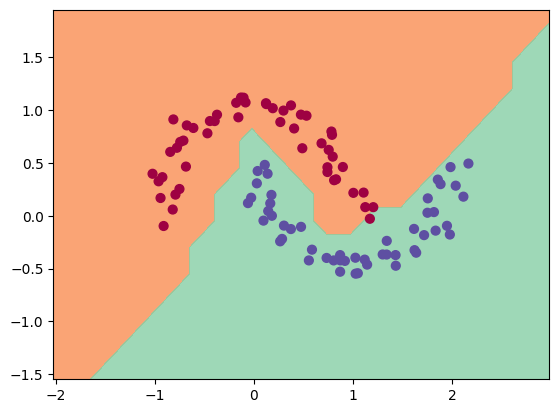

In [44]:
# visualize decision boundary

h = 0.25
x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                     np.arange(y_min, y_max, h))
Xmesh = np.c_[xx.ravel(), yy.ravel()]
inputs = [list(map(Value, xrow)) for xrow in Xmesh]
scores = list(map(model, inputs))
Z = np.array([s.data > 0 for s in scores])
Z = Z.reshape(xx.shape)

fig = plt.figure()
plt.contourf(xx, yy, Z, cmap=plt.cm.Spectral, alpha=0.8)
plt.scatter(X[:, 0], X[:, 1], c=y, s=40, cmap=plt.cm.Spectral)
plt.xlim(xx.min(), xx.max())
plt.ylim(yy.min(), yy.max())
